# **Quora Question pair similarity**

### **Description**
Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions
and connect with people who contribute unique insights and quality answers. This empowers
people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it’s no surprise that many people ask
similarly worded questions. Multiple questions with the same intent can cause seekers to spend
more time finding the best answer to their question, and make writers feel they need to answer
multiple versions of the same question. Quora values canonical questions because they provide a
better experience to active seekers and writers, and offer more value to both of these groups in the
long term.


### **Problem Statement:**
* Identify which questions asked on Quora are duplicates of questions that have already been asked.

* This can be helpful for providing instant responses to questions that have already been addressed.

### **Objective:**
* To predict which of the provided pairs of questions contain two questions with the same meaning. 

### **Real World/Business Objectives and Constraints:**

*   The cost of a mis-classification can be very high.
*   You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
*   No strict latency concerns.
*   Interpretability is partially important.

 
### **About Dataset**

The dataset "Train.csv" contains **404,290 rows**and **5 columns**

#### **Data fields**
> * **id** - the id of a training set question pair
> * **qid1, qid2** - unique ids of each question (only available in train.csv)
> * **question1, question2** - the full text of each question
> * **is_duplicate** - is the dependent variable, and the target variable is set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.




In [9]:
!gdown 1cGjXPdA2RJ98hqfO_TnPxl4VTA-0C0Nn
# https://drive.google.com/file/d/1cGjXPdA2RJ98hqfO_TnPxl4VTA-0C0Nn/view?usp=drive_link

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')


# **Data Exploration and EDA**

In [11]:
# Load the Dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv("D:/Desktop/EDA/EDA/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [12]:
# Check the Shape of dataset
df.shape

(404290, 6)

In [13]:
# Check the meta information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

* **id:** Looks like a simple rowID
* **qid{1, 2}:** The unique ID of each question in the pair
* **question{1, 2}:** The actual textual contents of the questions.
* **is_duplicate**: The label that we are trying to predict - whether the two questions are duplicates of each other.

In [14]:
# Available Columns
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

**1) Distribution of datapoints in Target Column (is_duplicate)**

- Number of duplicate(similar) and non-duplicate(non similar) questions

Total number of question pairs for training:   404290
--------------------------------------------------------------------------------
Distribution of Target (is_duplicate)
is_duplicate
0    255027
1    149263
Name: count, dtype: int64
--------------------------------------------------
is_duplicate
0    63.080215
1    36.919785
Name: proportion, dtype: float64


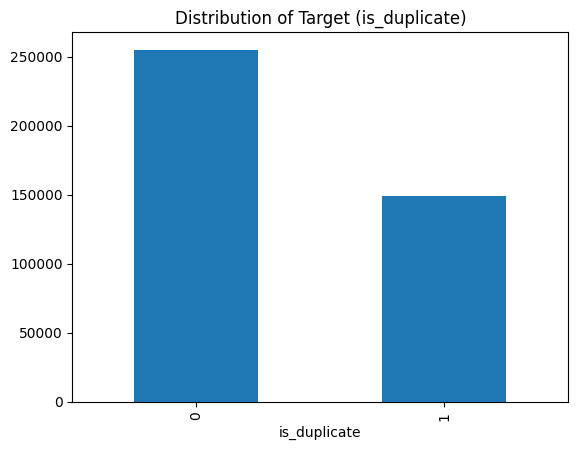

In [15]:
from bs4.element import ProcessingInstruction
df.groupby("is_duplicate")['id'].count().plot.bar()
plt.title("Distribution of Target (is_duplicate)")
print('Total number of question pairs for training:   {}'.format(len(df)))
print("-"*80)
print("Distribution of Target (is_duplicate)")
print(df['is_duplicate'].value_counts())
print("-"*50)
print(df['is_duplicate'].value_counts(normalize = True)*100)

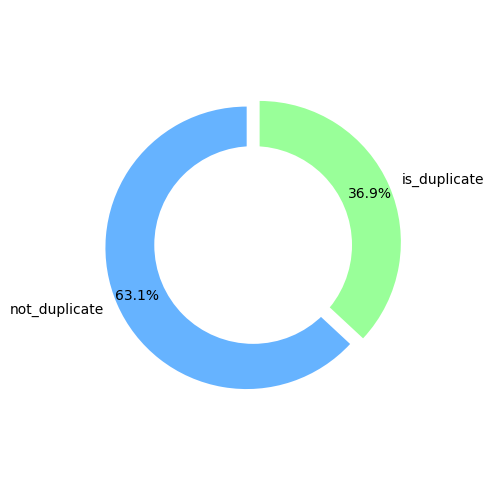

In [16]:
targets = df['is_duplicate'].value_counts()

# pie chart to visualize the distribution of customer churn
labels = ['not_duplicate', 'is_duplicate']
sizes = targets.values.tolist()

#colors
colors = ['#66b3ff', '#99ff99'] 

 
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05,0.05))
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout();

* Percentage of dissimilar pair of questions (is_duplicate = 0): **63.08 %**
* Percentage of similar pair of questions (is_duplicate = 1): **36.92 %**
> **The dataset given is an imbalanced dataset.**

**2) Number of Unique & Duplicate questions**

In [17]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
dup_qids = np.sum(qids.value_counts() > 1)
print("Total no. qids: ", len(qids))
print("Total no. unique qids: ", unique_qids)
print("Total no. of duplicated qids: ", dup_qids)
print ('Percentage of duplicated questions  {} %'.format(round(dup_qids/unique_qids*100,2)))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))



Total no. qids:  808580
Total no. unique qids:  537933
Total no. of duplicated qids:  111780
Percentage of duplicated questions  20.78 %
Max number of times a single question is repeated: 157


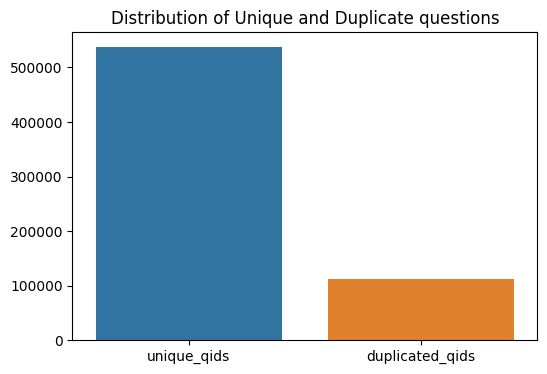

In [18]:
X = ["unique_qids" , "duplicated_qids"]
Y =  [unique_qids , dup_qids]

plt.figure(figsize=(6, 4))
plt.title ("Distribution of Unique and Duplicate questions")
sns.barplot(x=X,y=Y)
plt.show()



**3) Checking for Duplicates**

In [19]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


**4) Number of occurrences of each question**

Maximum number of times a single question is repeated: 157
Minimum number of times a single question is repeated: 0


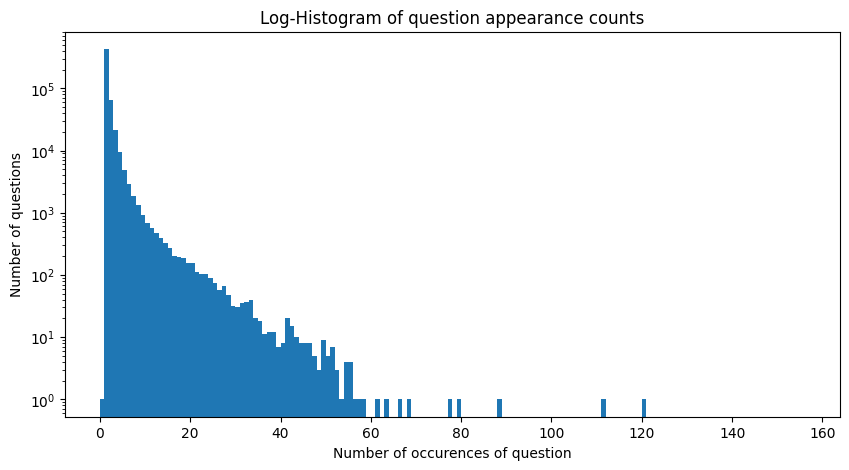

In [20]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,np.max(occurences)))
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print('Maximum number of times a single question is repeated: {}'.format(max(qids.value_counts())))
print('Minimum number of times a single question is repeated: {}'.format(np.min(occurences)))
plt.show()

When we include both question1 and question2 then count of total number of questions are 808580.
*      Out of these 808580 questions 537933 are unique questions and 111780 are repeated questions.
*      Most of the questions are repeated very few times, with very few questions appearing several times (and a few questions appearing many times).
*      There is only one question which is the most repeated one and it is repeated 157 times, which is an **outlier.**
*      There are some questions with very few characters, which does not make sense.

**Check for missing values**

In [21]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [23]:
# Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(axis=1)]
print(nan_rows)


            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


**We have 3 rows having Null values in question1 and question2 columns which can be filled by ' '**

In [25]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(axis=1)]
print(df.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [26]:
# check for duplicates in our dataset
df.duplicated().sum()

0

## **Sample data analysis**

In [27]:
# Sampling 4000 data points to enhance training speed and optimize memory usage.
new_df = df.sample(4000,random_state=42)
print("Shape of dataset:",new_df.shape)
new_df.head()

Shape of dataset: (4000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [28]:
# Check the meta information about the dataset
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 8067 to 206109
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            4000 non-null   int64 
 1   qid1          4000 non-null   int64 
 2   qid2          4000 non-null   int64 
 3   question1     4000 non-null   object
 4   question2     4000 non-null   object
 5   is_duplicate  4000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 218.8+ KB


In [29]:
print("Distribution of Output classes (is_duplicate)")
print(new_df.is_duplicate.value_counts())
print("_"*50)
print(new_df.is_duplicate.value_counts(normalize=True)*100)

Distribution of Output classes (is_duplicate)
is_duplicate
0    2522
1    1478
Name: count, dtype: int64
__________________________________________________
is_duplicate
0    63.05
1    36.95
Name: proportion, dtype: float64


* Percentage of dissimilar pair of questions (is_duplicate = 0): **63.05 %**
* Percentage of similar pair of questions (is_duplicate = 1): **36.95 %**
> **The sample dataset given is an imbalanced dataset with similar distribution of actual dataset**

# **Text Preprocessing**
Perform below actions on question1 and question2 columns of the dataset:
*   Convert entire text to lowercase
*   Remove html tags
*   Remove Stopwords
> Stop-words means the words which are occur frequently .
*   Expand Contractions
*   Remove Punctuations
*   Remove Special Characters
*   Remove hyperlinks
*   Apply Tokenization
*   Apply Stemming
> Stemming means the process of converting the words of a sentence to its non-changing portions.
*   Apply Lemmatization

In [31]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aditi\AppData\Roaming\nltk_data...


True

In [32]:
## initialise the inbuilt Stemmer and Lemmatizer.we can use either of them
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [33]:
def preprocess(q, flag):
    
    # Convert entire text to lowercase and strip blank spaces
    q = str(q).lower().strip()
    
    # Remove Special Characters
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    q = q.replace('+', ' plus ')
    q = q.replace('/', ' or ')
    q = q.replace('-', ' ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Expand Contractions
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        q = stemmer.stem(q)
    else:
        q = lemmatizer.lemmatize(q)        
    return q

    # Tokenize into words
    tokens = q.split()
    
    # Remove stop words                
    clean_tokens = [t for t in tokens if not t in stopwords.words("english")]
    

    # Stemming/Lemmatization
    if(flag == 'stem'):
        clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]

    q=' '.join([" ".join(clean_tokens)])
    return q

* We have converted everything to lower case.
* We have removed contractions.
* We have replaced currency symbols with currency names.
* We have also removed hyperlinks.
* We have removed non-alphanumeric characters.
* We have removed inflections with word lemmatizer.
* We have also removed HTML tags.

In [34]:
q1 = 'My Chinese name is Haichao Yu. What English na...'
preprocess(q1,'lem')

'my chinese name is haichao yu  what english na'

In [35]:
q2 = 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?'
preprocess(q2,'stem')

'find the remainder when 23  24   or math  is divided by 24 23'

In [36]:
q3 = 'www.google.co.in'
preprocess(q3,'lem')

'www google co in'

In [37]:
!pip install tqdm

from tqdm import tqdm, tqdm_notebook

**Basic Feature Extraction with Lemmatization**

In [38]:
# Register 'pandas.progress_apply' and `pandas.Series.map_apply` with 'tqdm'

tqdm.pandas()

> Add new columns "**Clean_q1_lem**","**q2_lem**" to the dataframe new_df.
> where, 
- **Clean_q1_lem** column represents preprocessed_q1 column after applying preprocess function with flag=lem
- **q2_lem** column represents preprocessed_q2 column after applying preprocess function with flag=lem


In [39]:
# new_df['q1_stem'] = new_df['question1'].progress_apply(lambda x: preprocess(x,'Stem'))
# new_df['q2_stem'] = new_df['question2'].progress_apply(lambda x: preprocess(x,'Stem'))

new_df['Clean_q1_lem'] = new_df['question1'].progress_apply(lambda x: preprocess(x,'lem'))
new_df['q2_lem'] = new_df['question2'].progress_apply(lambda x: preprocess(x,'lem'))
new_df.head()

100%|██████████| 4000/4000 [00:00<00:00, 9641.67it/s] 


,id,qid1,qid2,question1,question2,is_duplicate,Clean_q1_lem,q2_lem
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,how do i play pokémon go in korea,how do i play pokémon go in china
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,which is more advisable and better material fo...,what is the best server setup for buddypress
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,how do i improve logical programming skills,how can i improve my logical skills for progra...
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,how close we are to see 3rd world war,how close is a world war iii


# **Word Clouds**
>  The words which are bigger will occur more.

In [41]:
from random import randint
from wordcloud import WordCloud, STOPWORDS

# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)
    return wc_stopwords

# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(background_color="white", max_words=len(text),stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axes = plt.subplots(figsize=(10, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        #plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.imshow(wc, interpolation='bilinear')
        plt.xlabel('WordCloud')
        plt.axis("off")

Word Cloud for preprocesssed question1


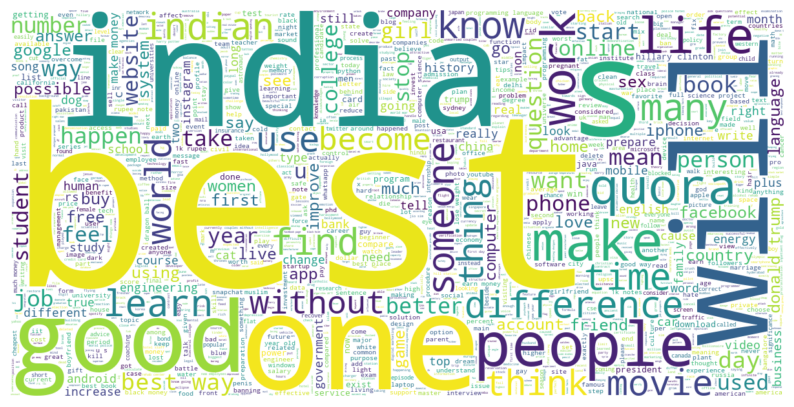

In [42]:
# Word Cloud for Preprocessed question1

print("Word Cloud for preprocesssed question1")
plot_wordcloud(' '.join(new_df.Clean_q1_lem.values.tolist()), wc_blue_color_func)

Word Cloud for preprocessed question2


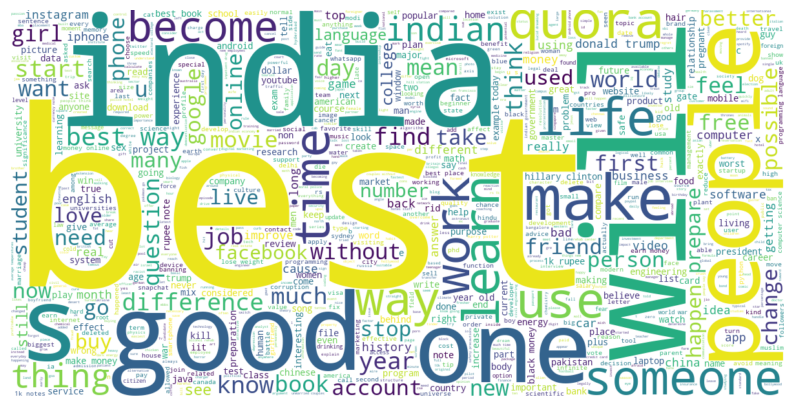

In [43]:
# Word Cloud for Preprocessed question2
print("Word Cloud for preprocessed question2")
plot_wordcloud(' '.join(new_df.q2_lem.values.tolist()), wc_blue_color_func)

Word Cloud for Duplicate Question pairs


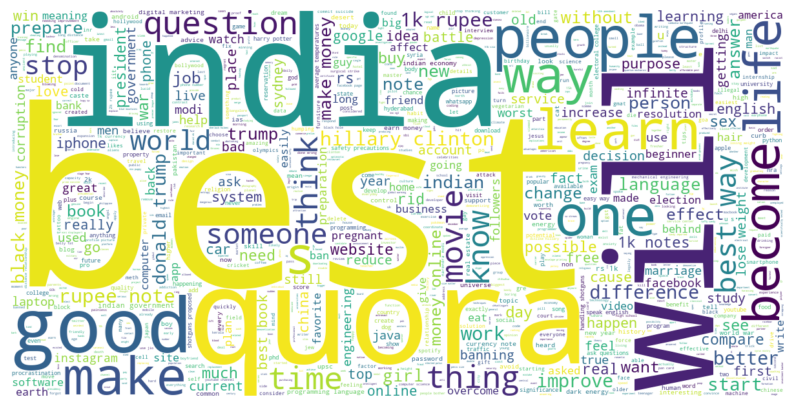

In [44]:
# Work Cloud for Duplicate Question Pairs

print ("Word Cloud for Duplicate Question pairs")
plot_wordcloud(' '.join(new_df['Clean_q1_lem'].loc[new_df['is_duplicate'] == 1].values.tolist() and new_df['q2_lem'].loc[new_df['is_duplicate'] == 1].values.tolist()), wc_blue_color_func)


Word Cloud for Non-Duplicate Question pairs


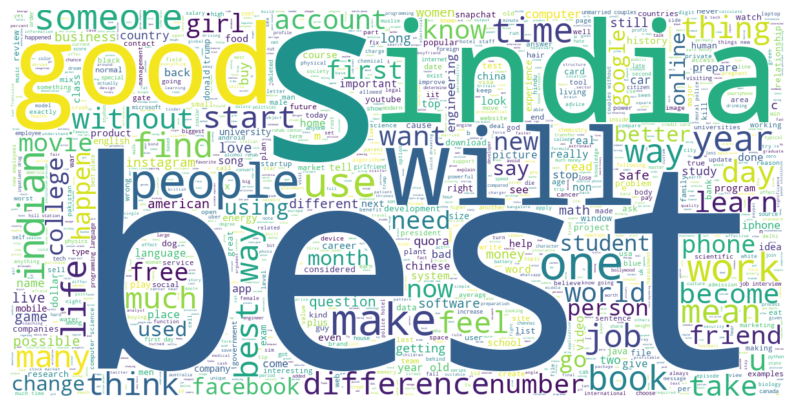

In [45]:
# Work Cloud for Non-Duplicate Question Pairs

print ("Word Cloud for Non-Duplicate Question pairs")
plot_wordcloud(' '.join(new_df['Clean_q1_lem'].loc[new_df['is_duplicate'] == 0].values.tolist() and new_df['q2_lem'].loc[new_df['is_duplicate'] == 0].values.tolist()), wc_blue_color_func)

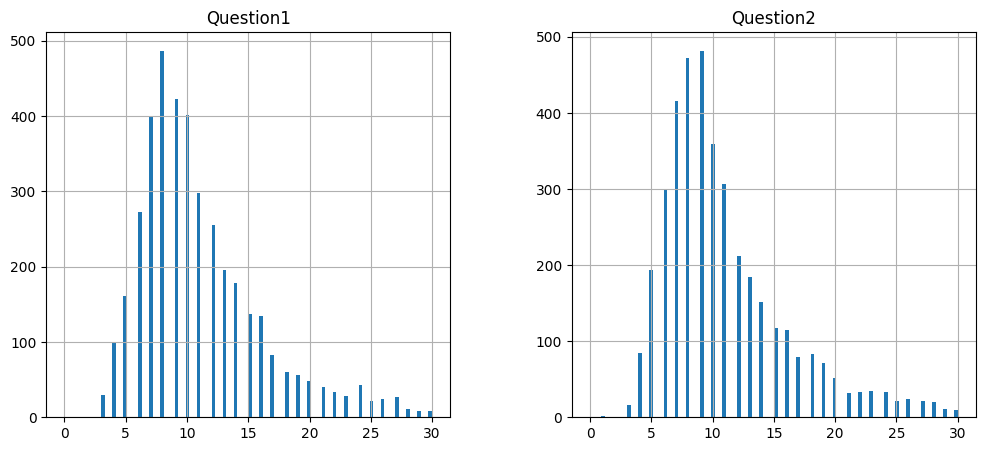

In [46]:
#Plot count of length of words in Clean_q1_lem and clean_q2_lem

Question1_count = [len(sentence.split()) for sentence in new_df.Clean_q1_lem]
Question2_count = [len(sentence.split()) for sentence in new_df.q2_lem]
pd.DataFrame({'Question1':Question1_count, 'Question2': Question2_count}).hist(bins=100, figsize=(12, 5), range=[0, 30])
plt.show()

In [47]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)

In [48]:
print("Percentage of Question1 having 0-30 words: ",get_word_percent(new_df.Clean_q1_lem,30 )*100)
print("Percentage of Question1 having 0-15 words: ",get_word_percent(new_df.Clean_q1_lem,15 )*100)
print("-"*80)
print("Percentage of Question2 having 0-30 words: ",get_word_percent(new_df.q2_lem, 30)*100)
print("Percentage of Question2 having 0-15 words: ",get_word_percent(new_df.q2_lem, 15)*100)

Percentage of Question1 having 0-30 words:  99.0
Percentage of Question1 having 0-15 words:  83.0
--------------------------------------------------------------------------------
Percentage of Question2 having 0-30 words:  98.0
Percentage of Question2 having 0-15 words:  82.0


**Observations :**
* We can notice that almost 99% of words are in range 0 to 15 for both Question1 and Question2.
* And they are very few questions in both Question1 and Question2 that have count of words greater than 15.

# **Feature Extraction**
We have divided this step in three parts
1. **Basic Features** : These features are extracted from preprocessed question1 and question2 and are stored in new dataframe named **bf_df**  where bf represents basic features
2. **StopWords and Token Features** : These features are extracted based on stopwords from original question1 and question2 from new_df and are stored in new dataframe named **sw_df** where sw represents stop words
3. **Fuzzy Features** : These features are extracted from fuzzywords of preprocessed question1 and question2 and are stored in new dataframe named **fuzzy_df**

## 1. Basic Features :
Let us construct few basic features which are described below:

*     **f_q1** = Frequency of qid1's
*     **f_q2** = Frequency of qid2's
*     **f(q1+q2)** = sum total of frequency of qid1 and qid2
*     **f(q1-q2)** = absolute difference of frequency of qid1 and qid2
*     **q1_char** = count of characters of Question1
*     **q2_char**  = count of characters of Question2
*     **q1_num_words** = Count of words in Question 1
*     **q2_num_words** = Count of words in Question 2
*     **total_word_num** = Sum of Q1_n_words and Q2_n_words
*     **diff_word_num** = absolute difference of Q1_n_words and Q2_n_words
*     **same_first_word** = This feature is 1 if both questions have same first word otherwise 0.
*     **same_last_word**  = This feature is 1 if both questions have same last word otherwise 0.
*    **unique_common_words** = Count of unique words which are common for both Question 1 and Question 2
*   **same_common_words** =  Count of words which are same and common for both Question 1 and Question 2
*   **total_unique_word_share** = (unique_common_words)/(total_word_num)
*   **total_same_word_share** = (same_common_words)/(unique_common_words)
*   **min_common_word_ratio** = Same_common_words divided by minimum number of words between question 1 and question 2.
*   **max_common_word_ratio** = Same_common_words divided by maximum number of words between question 1 and question 2.



In [49]:
#Basic_feature_df ->bf_df

bf_df=pd.concat([new_df['id'],new_df['qid1'],new_df['qid2'],new_df['Clean_q1_lem'],new_df['q2_lem'],new_df['is_duplicate']],axis=1)

bf_df.head()

,id,qid1,qid2,Clean_q1_lem,q2_lem,is_duplicate
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0
226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1
73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1


In [50]:
def doesMatch (q, match):
    q1, q2 = q['Clean_q1_lem'], q['q2_lem']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[match]==q2[match]:
        return 1
    else:
        return 0

In [51]:
# basic features
bf_df['f_q1'] = bf_df.groupby('qid1')['qid1'].transform('count')  #  Frequency of qid1's
bf_df['f_q2'] = bf_df.groupby('qid2')['qid2'].transform('count') #  Frequency of qid2's
bf_df['f(q1 + q2)'] = bf_df['f_q1']+bf_df['f_q2']  # sum total of frequency of qid1 and qid2
bf_df['f(q1 - q2)'] = abs(bf_df['f_q1']- bf_df['f_q2']) # absolute difference of frequency of qid1 and qid2

bf_df['q1_char'] = bf_df.Clean_q1_lem.apply(len)  # count of characters of Question1
bf_df['q2_char'] = bf_df.q2_lem.apply(len)  # count of characters of Question2

bf_df['q1_num_words'] = bf_df['Clean_q1_lem'].apply(lambda row: len(row.split(" "))) # Count of words in Question 1
bf_df['q2_num_words'] = bf_df['q2_lem'].apply(lambda row: len(row.split(" "))) # Count of words in Question 2

bf_df['total_word_num'] = bf_df['q1_num_words']+bf_df['q2_num_words'] # sum of q1_num_words and q2_num_words
bf_df['diff_word_num'] = abs(bf_df['q1_num_words']-bf_df['q2_num_words']) #  absolute difference of q1_num_words and q2_num_words

bf_df['same_first_word'] = bf_df.apply(lambda x: doesMatch(x, 0) ,axis=1) # This feature is 1 if both questions have same first word otherwise 0.
bf_df['same_last_word'] = bf_df.apply(lambda x: doesMatch(x, -1) ,axis=1) # This feature is 1 if both questions have same last word otherwise 0.

bf_df['unique_common_words'] = bf_df.apply(lambda x: len(set(x.Clean_q1_lem.split()).union(set(x.q2_lem.split()))) ,axis=1) # Count of words which are  unique and common for both Question 1 and Question 2
bf_df['same_common_words'] = bf_df.apply(lambda x: len(set(x.Clean_q1_lem.split()).intersection(set(x.q2_lem.split()))) ,axis=1) # Count of words which are same and common for both Question 1 and Question 2

bf_df['total_unique_word_share'] = bf_df['unique_common_words']/bf_df['total_word_num']
bf_df['total_same_word_share'] = bf_df['same_common_words']/bf_df['unique_common_words']
bf_df['min_common_word_ratio'] = bf_df['same_common_words'] / bf_df.apply(lambda x: min(len(set(x.Clean_q1_lem.split())), len(set(x.q2_lem.split()))) ,axis=1) 
bf_df['max_common_word_ratio'] = bf_df['same_common_words'] / bf_df.apply(lambda x: max(len(set(x.Clean_q1_lem.split())), len(set(x.q2_lem.split()))) ,axis=1)

bf_df['q1_len'] = bf_df['Clean_q1_lem'].str.len() 
bf_df['q2_len'] = bf_df['q2_lem'].str.len()


In [52]:
bf_df.head(2).T

,8067,368101
id,8067,368101
qid1,15738,12736
qid2,15739,104117
Clean_q1_lem,how do i play pokémon go in korea,what are some of the best side dishes for crab...
q2_lem,how do i play pokémon go in china,what are some good side dishes for buffalo chi...
is_duplicate,0,0
f_q1,1,1
f_q2,1,1
f(q1 + q2),2,2
f(q1 - q2),0,0


In [53]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['Clean_q1_lem'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['q2_lem'].split(" ")))    
    return len(w1 & w2)

bf_df['word_common'] = bf_df.apply(common_words, axis=1)

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['Clean_q1_lem'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['q2_lem'].split(" ")))    
    return (len(w1) + len(w2))

bf_df['word_total'] = bf_df.apply(total_words, axis=1)

bf_df['word_share'] = round(bf_df['word_common']/bf_df['word_total'],2)

In [54]:
bf_df.head(2).T

,8067,368101
id,8067,368101
qid1,15738,12736
qid2,15739,104117
Clean_q1_lem,how do i play pokémon go in korea,what are some of the best side dishes for crab...
q2_lem,how do i play pokémon go in china,what are some good side dishes for buffalo chi...
is_duplicate,0,0
f_q1,1,1
f_q2,1,1
f(q1 + q2),2,2
f(q1 - q2),0,0


## **EDA for Basic Features**

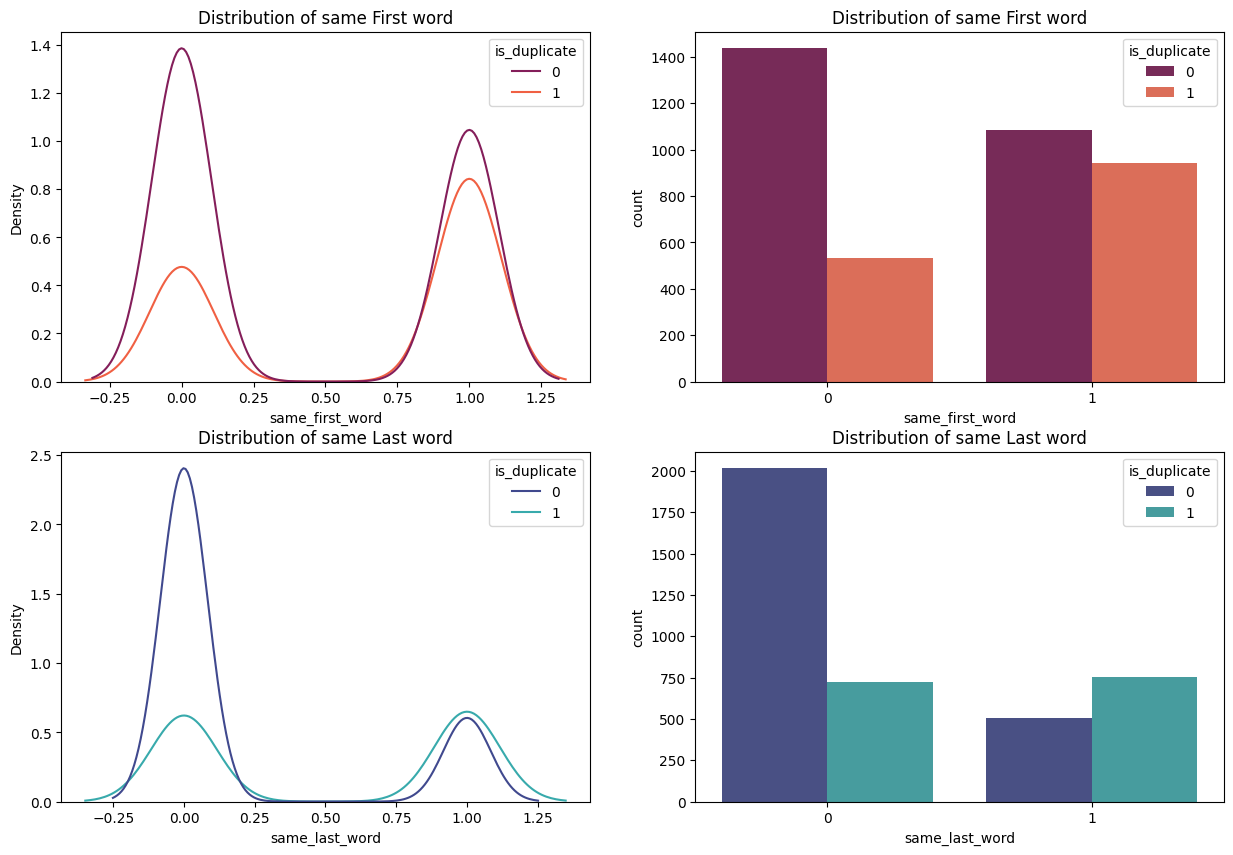

In [55]:
fig, ax =plt.subplots(2,2,figsize=(15,10))
ax[0][0].title.set_text('Distribution of same First word')
sns.kdeplot(bf_df,x='same_first_word', hue='is_duplicate', palette="rocket", ax=ax[0][0])
ax[0][1].title.set_text('Distribution of same First word')
sns.countplot(bf_df,x='same_first_word', hue='is_duplicate', palette="rocket", ax=ax[0][1])

ax[1][0].title.set_text('Distribution of same Last word')
sns.kdeplot(bf_df,x='same_last_word', hue='is_duplicate', palette="mako", ax=ax[1][0])
ax[1][1].title.set_text('Distribution of same Last word')
sns.countplot(bf_df,x='same_last_word', hue='is_duplicate', palette="mako", ax=ax[1][1])
plt.show()

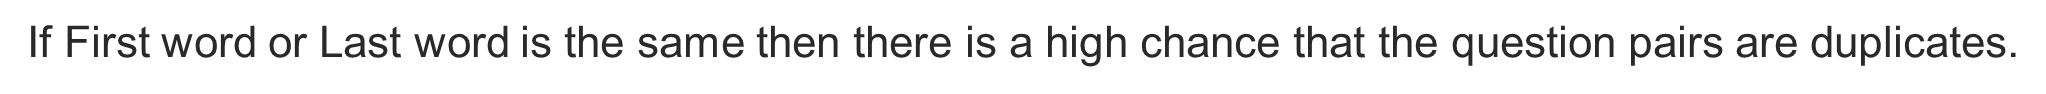

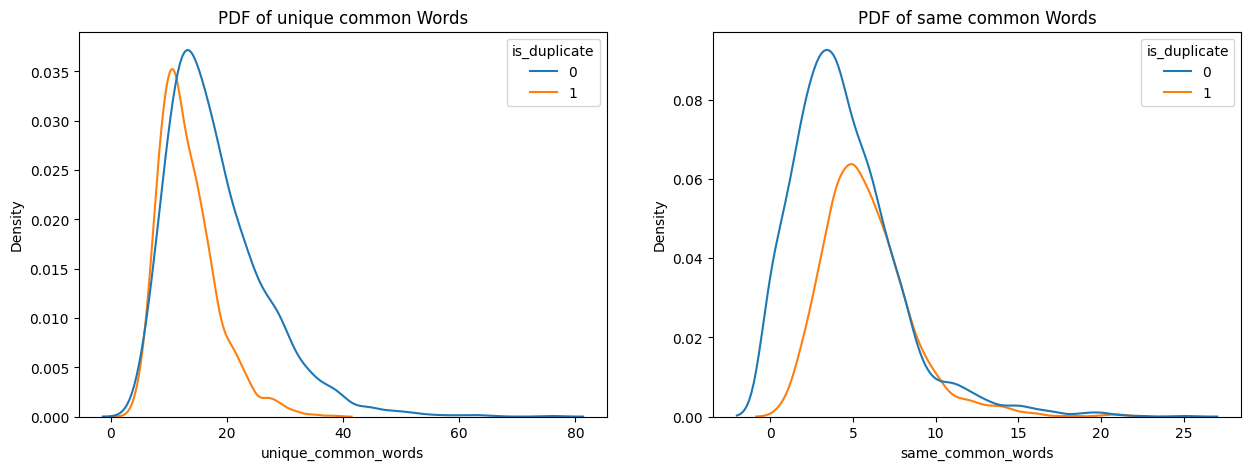

In [56]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of unique common Words')
sns.kdeplot(bf_df,x=bf_df['unique_common_words'], hue=bf_df.is_duplicate, ax=ax[0])
ax[1].title.set_text('PDF of same common Words')
sns.kdeplot(bf_df,x=bf_df['same_common_words'], hue=bf_df.is_duplicate, ax=ax[1])
plt.show()

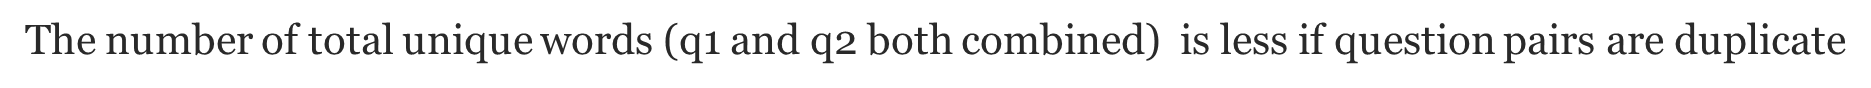

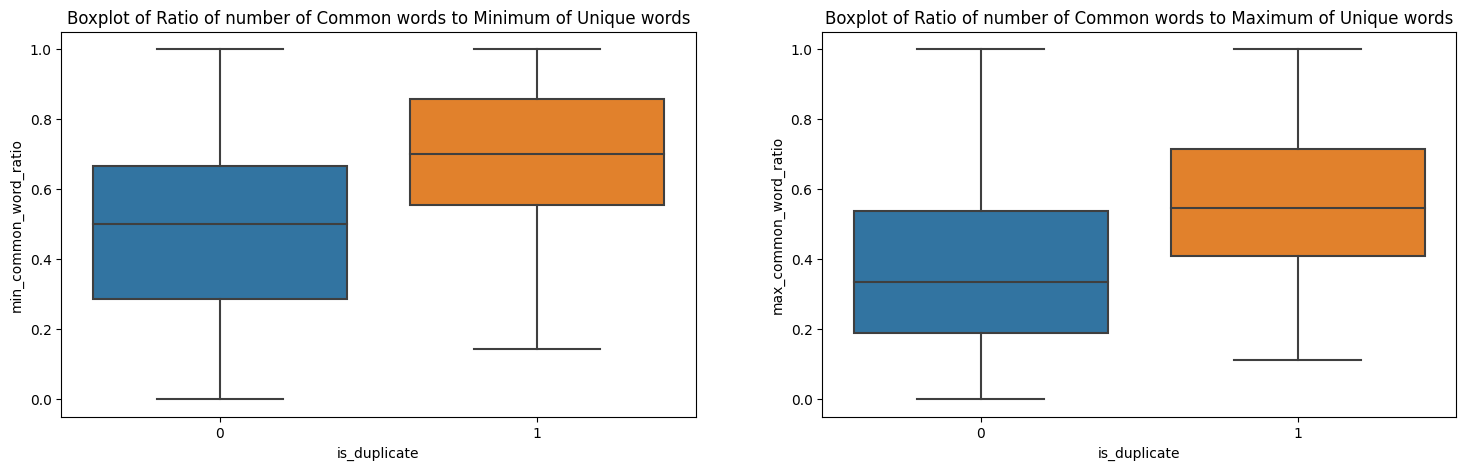

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Boxplot of Ratio of number of Common words to Minimum of Unique words
ax[0].set_title('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(data=bf_df, x='is_duplicate', y='min_common_word_ratio', ax=ax[0])

# Boxplot of Ratio of number of Common words to Maximum of Unique words
ax[1].set_title('Boxplot of Ratio of number of Common words to Maximum of Unique words')
sns.boxplot(data=bf_df, x='is_duplicate', y='max_common_word_ratio', ax=ax[1])

plt.show()


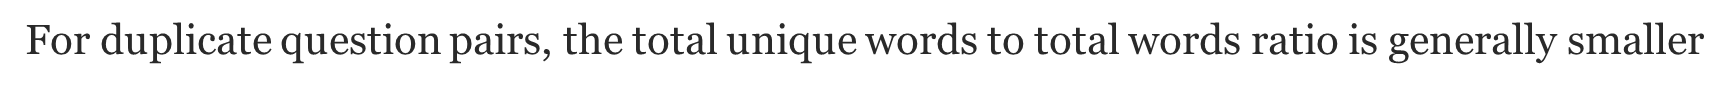


## 2. StopWords and Tokens Features :
> * **Token:** You get a token by splitting sentence a space
> * **Stop_Word**: stop words as per NLTK.
> * **Word** : A token that is not a stop_word

*   **cwc_min** : Ratio of common_word_count to min length of word count of Q1 and Q2
> cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
*   **cwc_max** : Ratio of common_word_count to max length of word count of Q1 and Q2
> cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
*   **csc_min** : Ratio of common_stop_count to min length of stop count of Q1 and Q2
>  csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
*   **csc_max** : Ratio of common_stop_count to max length of stop count of Q1 and Q2
> csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
*   **ctc_min** : Ratio of common_token_count to min length of token count of Q1 and Q2
>  ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
*   **ctc_max** : Ratio of common_token_count to max length of token count of Q1 and Q2
>  ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
*   **last_word_eq** : Check if Last word of both questions is equal or not
>  last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
*   **first_word_eq** : Check if First word of both questions is equal or not
>  first_word_eq = int(q1_tokens[0] == q2_tokens[0])
*   **abs_len_diff** : Abs. length difference
> abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
*   **mean_len** : Average Token Length of both questions
> mean_len = (len(q1_tokens) + len(q2_tokens))/2
*   **longest_substr_ratio** : Ratio of length longest common substring to min length of token count of Q1 and Q2
>  longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [58]:
# stopword_token_df --> SW_df
SW_df=pd.concat([new_df['question1'],new_df['question2'],new_df['is_duplicate']],axis=1)
SW_df.head()

,question1,question2,is_duplicate
8067,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,How close we are to see 3rd world war?,How close is a World War III?,1


In [59]:
!pip install distance

import distance

                                              0.0/180.3 kB ? eta -:--:--
     -----------------------------------   174.1/180.3 kB 10.2 MB/s eta 0:00:01
     -------------------------------------- 180.3/180.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16283 sha256=ff1a84a6a689d88885b97d649d9f3419a13ff8c6cae2871683cc18ba8a70ba98
  Stored in directory: c:\users\aditi\appdata\local\pip\cache\wheels\e8\bb\de\f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [60]:
# stopword and token features  
def get_token_features(row):   
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*11
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    # Absolute length features
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    # get the Longest Common sub string

    def get_longest_substr_ratio(q1, q2):
        strs = list(distance.lcsubstrings(q1, q2))
        if len(strs) == 0:
            return 0
        else:            
            token_features[10] = len(strs[0]) / (min(len(q1), len(q1)) + 1)
            return token_features[10]
            
    return token_features


In [61]:
token_features = new_df.apply(get_token_features, axis=1)

SW_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
SW_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
SW_df["csc_min"]       = list(map(lambda x: x[2], token_features))
SW_df["csc_max"]       = list(map(lambda x: x[3], token_features))
SW_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
SW_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
SW_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
SW_df["first_word_eq"] = list(map(lambda x: x[7], token_features))
SW_df['abs_len_diff']  = list(map(lambda x: x[8], token_features))
SW_df['mean_len']      = list(map(lambda x: x[9], token_features))
SW_df['longest_substr_ratio'] = list(map(lambda x: x[10], token_features))

SW_df.head(2).T

,8067,368101
question1,How do I play Pokémon GO in Korea?,What are some of the best side dishes for crab...
question2,How do I play Pokémon GO in China?,What are some good side dishes for buffalo chi...
is_duplicate,0,0
cwc_min,0.833319,0.499992
cwc_max,0.833319,0.499992
csc_min,0.99995,0.999967
csc_max,0.99995,0.599988
ctc_min,0.874989,0.666659
ctc_max,0.874989,0.54545
last_word_eq,0,0


## **EDA for Stopwords and Token features**

In [62]:
SW_df.columns

Index(['question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'longest_substr_ratio'],
      dtype='object')

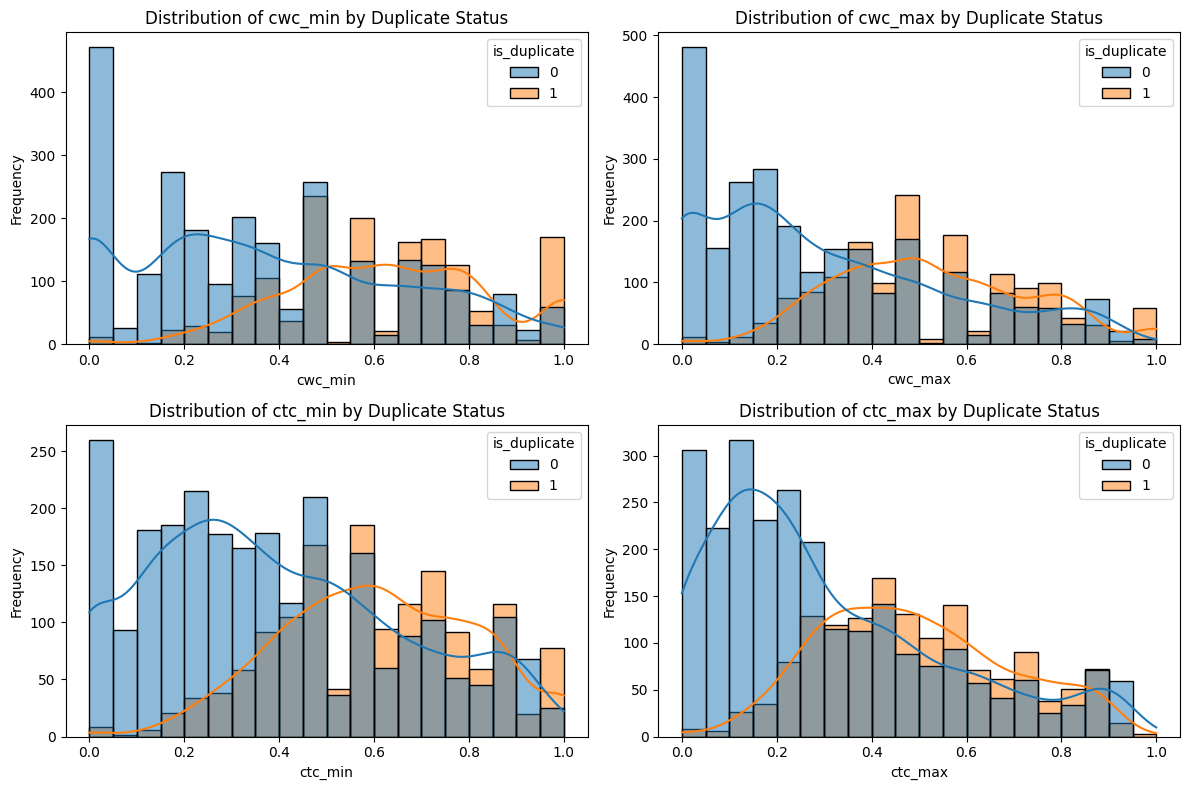

In [63]:
# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Adjust bin size and plot histograms
sns.histplot(data=SW_df, x='cwc_min', hue='is_duplicate', bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of cwc_min by Duplicate Status')
axes[0, 0].set_xlabel('cwc_min')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(data=SW_df, x='cwc_max', hue='is_duplicate', bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of cwc_max by Duplicate Status')
axes[0, 1].set_xlabel('cwc_max')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(data=SW_df, x='ctc_min', hue='is_duplicate', bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of ctc_min by Duplicate Status')
axes[1, 0].set_xlabel('ctc_min')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(data=SW_df, x='ctc_max', hue='is_duplicate', bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of ctc_max by Duplicate Status')
axes[1, 1].set_xlabel('ctc_max')
axes[1, 1].set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

* These histograms provide insights into the distribution of the ratios of common non-stopwords and common tokens between question pairs. 
* The skewness of the distributions suggests that there is a variation in the similarity of non-stopwords and tokens between duplicate and non-duplicate question pairs.

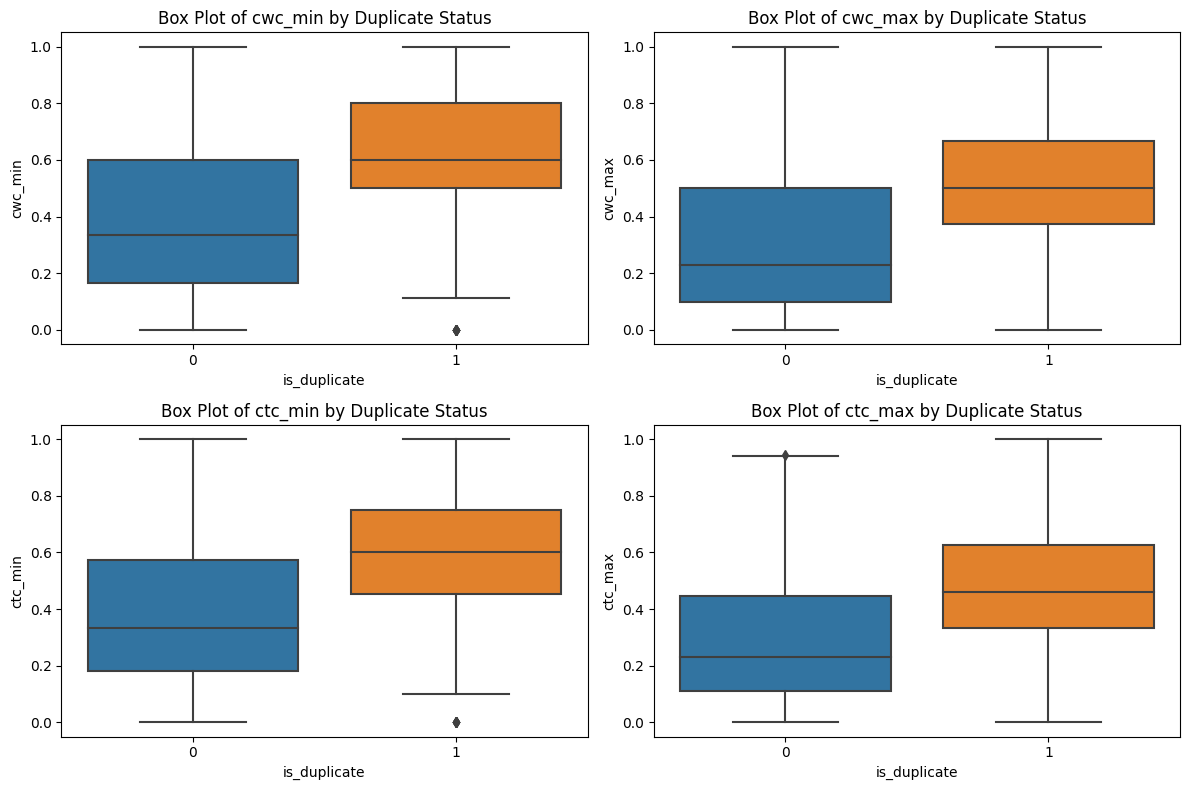

In [64]:
# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot boxplots
sns.boxplot(data=SW_df, x='is_duplicate', y='cwc_min', ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of cwc_min by Duplicate Status')
axes[0, 0].set_xlabel('is_duplicate')
axes[0, 0].set_ylabel('cwc_min')

sns.boxplot(data=SW_df, x='is_duplicate', y='cwc_max', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of cwc_max by Duplicate Status')
axes[0, 1].set_xlabel('is_duplicate')
axes[0, 1].set_ylabel('cwc_max')

sns.boxplot(data=SW_df, x='is_duplicate', y='ctc_min', ax=axes[1, 0])
axes[1, 0].set_title('Box Plot of ctc_min by Duplicate Status')
axes[1, 0].set_xlabel('is_duplicate')
axes[1, 0].set_ylabel('ctc_min')

sns.boxplot(data=SW_df, x='is_duplicate', y='ctc_max', ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of ctc_max by Duplicate Status')
axes[1, 1].set_xlabel('is_duplicate')
axes[1, 1].set_ylabel('ctc_max')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

* These boxplots provide insights into the distribution and variation of the ratios of common non-stopwords and common stopwords between duplicate and non-duplicate question pairs. 
* The differences in the medians suggest that these features can potentially be useful in distinguishing between duplicate and non-duplicate pairs.

# 3. Fuzzy Features:
*      **fuzz_ratio** : fuzzyWuzzy has a ratio function that calculates the standard Levenshtein distance similarity ratio between two sequences.
*      **fuzz_partial_ratio** : The partial ratio helps us to perform substring matching. This takes the shortest string and compares it with all the substrings of the same length.
*      **token_set_ratio** : Token set ratio performs a set operation that takes out the common tokens instead of just tokenizing the strings, sorting, and then pasting the tokens back together. Extra or same repeated words do not matter.
*      **token_sort_ratio** : In token sort ratio, the strings are tokenized and pre-processed by converting to lower case and getting rid of punctuation. The strings are then sorted alphabetically and joined together. Post this, the Levenshtein distance similarity ratio is calculated between the strings.



In [65]:
# fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

# fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

# token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

# token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [75]:
# fuzzy_df
fuzzy_df=pd.concat([new_df['Clean_q1_lem'],new_df['q2_lem'],new_df['is_duplicate']],axis=1)

* **FuzzyWuzzy** is a library of Python which is used for string matching.
* Fuzzy string matching is the process of finding strings that match a given pattern.

In [76]:
! pip install fuzzywuzzy
from fuzzywuzzy import fuzz

In [77]:
# fuzzy features
def fetch_fuzzy_features(row):
    
    q1 = row['Clean_q1_lem']
    q2 = row['q2_lem']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

fuzzy_features = fuzzy_df.apply(fetch_fuzzy_features, axis=1)

In [78]:
# Creating new feature columns for fuzzy features
fuzzy_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
fuzzy_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
fuzzy_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
fuzzy_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

fuzzy_df.head(2).T

,8067,368101
Clean_q1_lem,how do i play pokémon go in korea,what are some of the best side dishes for crab...
q2_lem,how do i play pokémon go in china,what are some good side dishes for buffalo chi...
is_duplicate,0,0
fuzz_ratio,88,73
fuzz_partial_ratio,88,72
token_sort_ratio,81,73
token_set_ratio,90,73


## **EDA on Fuzzy Features**

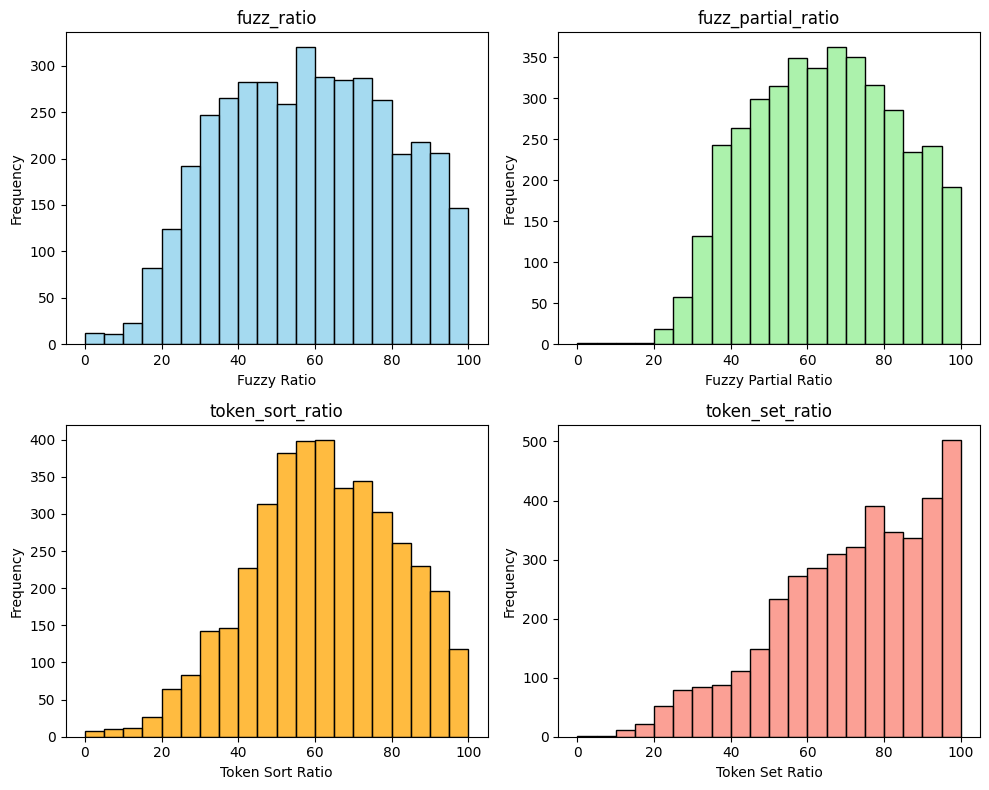

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Adjust bin size and plot histograms
sns.histplot(fuzzy_df['fuzz_ratio'], ax=axes[0, 0], bins=20, color='skyblue')
axes[0, 0].set_title('fuzz_ratio')
axes[0, 0].set_xlabel('Fuzzy Ratio')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(fuzzy_df['fuzz_partial_ratio'], ax=axes[0, 1], bins=20, color='lightgreen')
axes[0, 1].set_title('fuzz_partial_ratio')
axes[0, 1].set_xlabel('Fuzzy Partial Ratio')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(fuzzy_df['token_sort_ratio'], ax=axes[1, 0], bins=20, color='orange')
axes[1, 0].set_title('token_sort_ratio')
axes[1, 0].set_xlabel('Token Sort Ratio')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(fuzzy_df['token_set_ratio'], ax=axes[1, 1], bins=20, color='salmon')
axes[1, 1].set_title('token_set_ratio')
axes[1, 1].set_xlabel('Token Set Ratio')
axes[1, 1].set_ylabel('Frequency')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


ValueError: Could not interpret input 'fuzz_ratio'

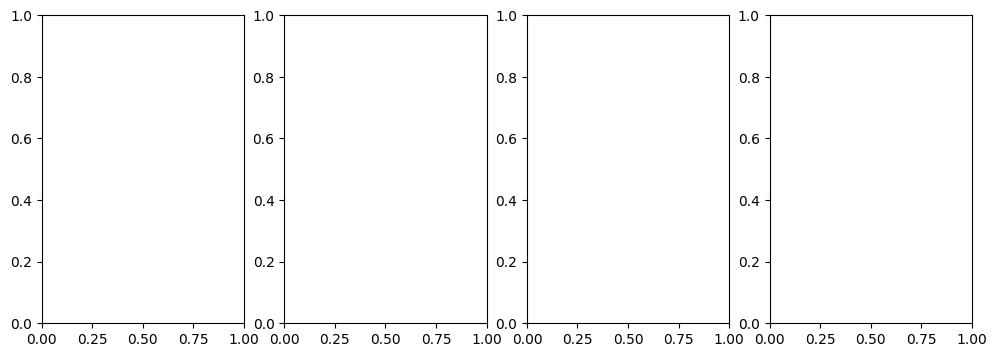

In [70]:

# Set up figure and axes
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# Box plot for fuzz_ratio
sns.boxplot(data=fuzzy_df, x='is_duplicate', y='fuzz_ratio', ax=axes[0])
axes[0].set_title('Box Plot of fuzz_ratio')
axes[0].set_xlabel('Duplicate Status')
axes[0].set_ylabel('Fuzzy Ratio')

# Box plot for fuzz_partial_ratio
sns.boxplot(data=fuzzy_df, x='is_duplicate', y='fuzz_partial_ratio', ax=axes[1])
axes[1].set_title('Box Plot of fuzz_partial_ratio')
axes[1].set_xlabel('Duplicate Status')
axes[1].set_ylabel('Fuzzy Partial Ratio')

# Box plot for token_sort_ratio
sns.boxplot(data=fuzzy_df, x='is_duplicate', y='token_sort_ratio', ax=axes[2])
axes[2].set_title('Box Plot of token_sort_ratio')
axes[2].set_xlabel('Duplicate Status')
axes[2].set_ylabel('Token Sort Ratio')

# Box plot for token_set_ratio
sns.boxplot(data=fuzzy_df, x='is_duplicate', y='token_set_ratio', ax=axes[3])
axes[3].set_title('Box Plot of token_set_ratio')
axes[3].set_xlabel('Duplicate Status')
axes[3].set_ylabel('Token Set Ratio')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



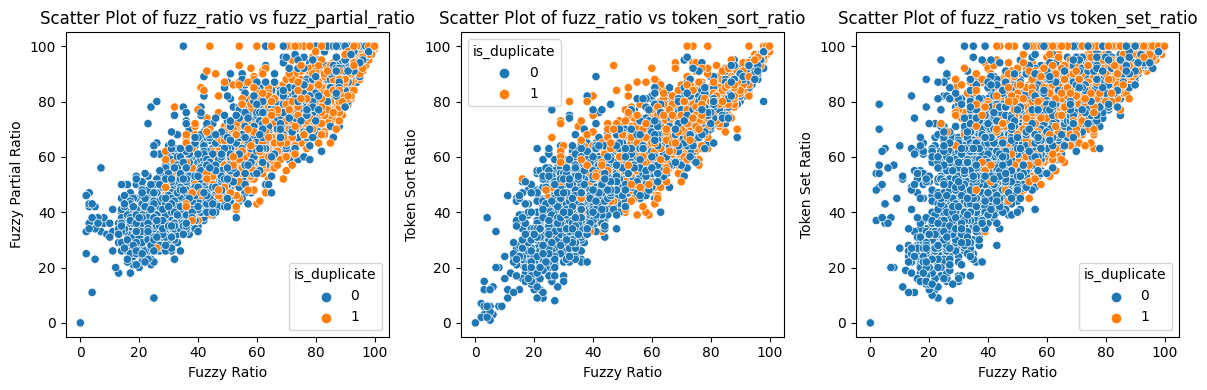

In [ ]:


# Set up figure and axes
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Scatter plot of fuzz_ratio vs fuzz_partial_ratio
sns.scatterplot(data=fuzzy_df, x='fuzz_ratio', y='fuzz_partial_ratio', hue='is_duplicate', ax=axes[0])
axes[0].set_title('Scatter Plot of fuzz_ratio vs fuzz_partial_ratio')
axes[0].set_xlabel('Fuzzy Ratio')
axes[0].set_ylabel('Fuzzy Partial Ratio')

# Scatter plot of fuzz_ratio vs token_sort_ratio
sns.scatterplot(data=fuzzy_df, x='fuzz_ratio', y='token_sort_ratio', hue='is_duplicate', ax=axes[1])
axes[1].set_title('Scatter Plot of fuzz_ratio vs token_sort_ratio')
axes[1].set_xlabel('Fuzzy Ratio')
axes[1].set_ylabel('Token Sort Ratio')

# Scatter plot of fuzz_ratio vs token_set_ratio
sns.scatterplot(data=fuzzy_df, x='fuzz_ratio', y='token_set_ratio', hue='is_duplicate', ax=axes[2])
axes[2].set_title('Scatter Plot of fuzz_ratio vs token_set_ratio')
axes[2].set_xlabel('Fuzzy Ratio')
axes[2].set_ylabel('Token Set Ratio')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



Most of the plots have certain overlapping, but it can somehow work out separability.

In [74]:
print(df.columns)


Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [71]:
# Dataset with extracted features
data=pd.concat([ new_df['id'],new_df[ 'qid1'], new_df['qid2'],
                      new_df['Clean_q1_lem'],bf_df['q1_len'],bf_df['q1_num_words'],new_df[ 'q2_lem'],bf_df['q2_len'],bf_df['q2_num_words'],new_df[ 'is_duplicate'],
                      bf_df['word_common'], bf_df['word_total'], bf_df['word_share'],SW_df['cwc_min'], SW_df['cwc_max'], SW_df['csc_min'], SW_df['csc_max'],
                      SW_df['ctc_min'], SW_df['ctc_max'],SW_df['first_word_eq'],SW_df['last_word_eq'],SW_df['abs_len_diff'],SW_df['mean_len'], SW_df['longest_substr_ratio'],
                      fuzzy_df['fuzz_ratio'], fuzzy_df['fuzz_partial_ratio'], fuzzy_df['token_sort_ratio'],fuzzy_df['token_set_ratio'] ],axis=1)


KeyError: 'fuzz_ratio'

In [72]:
data.head(2).T

NameError: name 'data' is not defined

In [73]:
data.info()

NameError: name 'data' is not defined

In [ ]:
from google.colab import files

data.to_csv('data.csv')
files.download('data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>